In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from sklearn.feature_selection import f_classif, f_regression, SelectKBest, chi2
from sklearn.ensemble          import IsolationForest

from sklearn.model_selection   import train_test_split
from sklearn.grid_search       import GridSearchCV
from sklearn.ensemble          import RandomForestRegressor
from sklearn.metrics           import mean_squared_error, mean_absolute_error, median_absolute_error

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import _pickle           as cPickle

import itertools
import argparse

from commonModel import loadData, FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS, TARGET_COLUMN

modelFileName = "model.pkl"
dataFileName  = "input/NizhnyNovgorod.csv"

Model = None
with open( modelFileName, 'rb') as fid:
        Model = cPickle.load(fid)
allDataFrame = loadData( dataFileName, COLUMN_TYPE='ALL' )

allDataFrame.head(10)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Tokenization took: 25.88 ms
Type conversion took: 48.88 ms
Parser memory cleanup took: 0.00 ms
Tokenization took: 12.83 ms
Type conversion took: 39.50 ms
Parser memory cleanup took: 0.01 ms
Shape of the data with all features: (109400, 11)
Shape of the data with numerical features: (109400, 11)
List of features contained our dataset: ['type', 'price', 'longitude', 'latitude', 'total_square', 'living_square', 'kitchen_square', 'number_of_rooms', 'floor_number', 'number_of_floors', 'building_type']
Shape of the data with numerical features: (63533, 11)
RobustScaler  [59007.04176027] [27882.38455357]
Shape of the data with numerical features: (46559, 11)


,type,price,longitude,latitude,total_square,living_square,kitchen_square,number_of_rooms,floor_number,number_of_floors,building_type
0,Вторичка,2850000.0,44.075417,56.283864,43.0,14.0,11.0,1,9,17,
1,Вторичка,8200000.0,43.942485,56.301539,98.5,52.0,14.0,3,3,17,
2,Вторичка,2600000.0,43.923782,56.310448,64.0,42.0,6.0,4,2,5,
3,Вторичка,2750000.0,44.064952,56.291499,50.0,30.0,9.0,2,3,5,
4,Вторичка,2650000.0,43.957127,56.329128,45.0,31.0,6.0,2,2,5,Кирпичный
5,Вторичка,2400000.0,44.023674,56.316345,76.0,44.0,12.0,2,6,9,
6,Вторичка,3700000.0,43.996545,56.317807,45.0,37.0,6.5,2,2,8,Кирпичный
7,Вторичка,3550000.0,44.079100,56.303541,41.8,18.6,11.3,1,9,9,Кирпичный
9,Вторичка,1900000.0,44.001350,56.310740,57.0,27.0,12.0,1,6,12,
12,Вторичка,4760000.0,43.943589,56.295000,105.0,64.0,10.0,4,8,9,Кирпичный


In [2]:
from commonModel import FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS

import warnings
warnings.filterwarnings('ignore')

NUMERICAL_COLUMNS = FLOAT_COLUMNS + INT_COLUMNS
testDataFrame = allDataFrame[NUMERICAL_COLUMNS]

FEATURES = list( testDataFrame.columns ); FEATURES.remove( TARGET_COLUMN )
COLUMNS  = list( testDataFrame.columns ); LABEL = TARGET_COLUMN;

index       = testDataFrame.index;
Y_dataFrame = testDataFrame    [[ TARGET_COLUMN ]];       Y_values = Y_dataFrame.values;
X_dataFrame = testDataFrame.drop( TARGET_COLUMN, axis=1); X_values = X_dataFrame.values;
Y_values    = Y_values.ravel()

Y_predict = Model.predict( X_values )

print( "Errors on the test set" )
print( "mean square:     ", mean_squared_error   ( Y_values, Y_predict ) )
print( "mean absolute:   ", mean_absolute_error  ( Y_values, Y_predict ) )
print( "median_absolute: ", median_absolute_error( Y_values, Y_predict ) )



Errors on the test set
mean square:      293443963532.73145
mean absolute:    169478.5404388095
median_absolute:  59415.77380952332


threshold =   2.5, good =      24898, bad =      21661, err = 0.4652376554479263
threshold =   5.0, good =      34973, bad =      11586, err = 0.24884555080650358
threshold =  10.0, good =      41791, bad =       4768, err = 0.1024076977598316


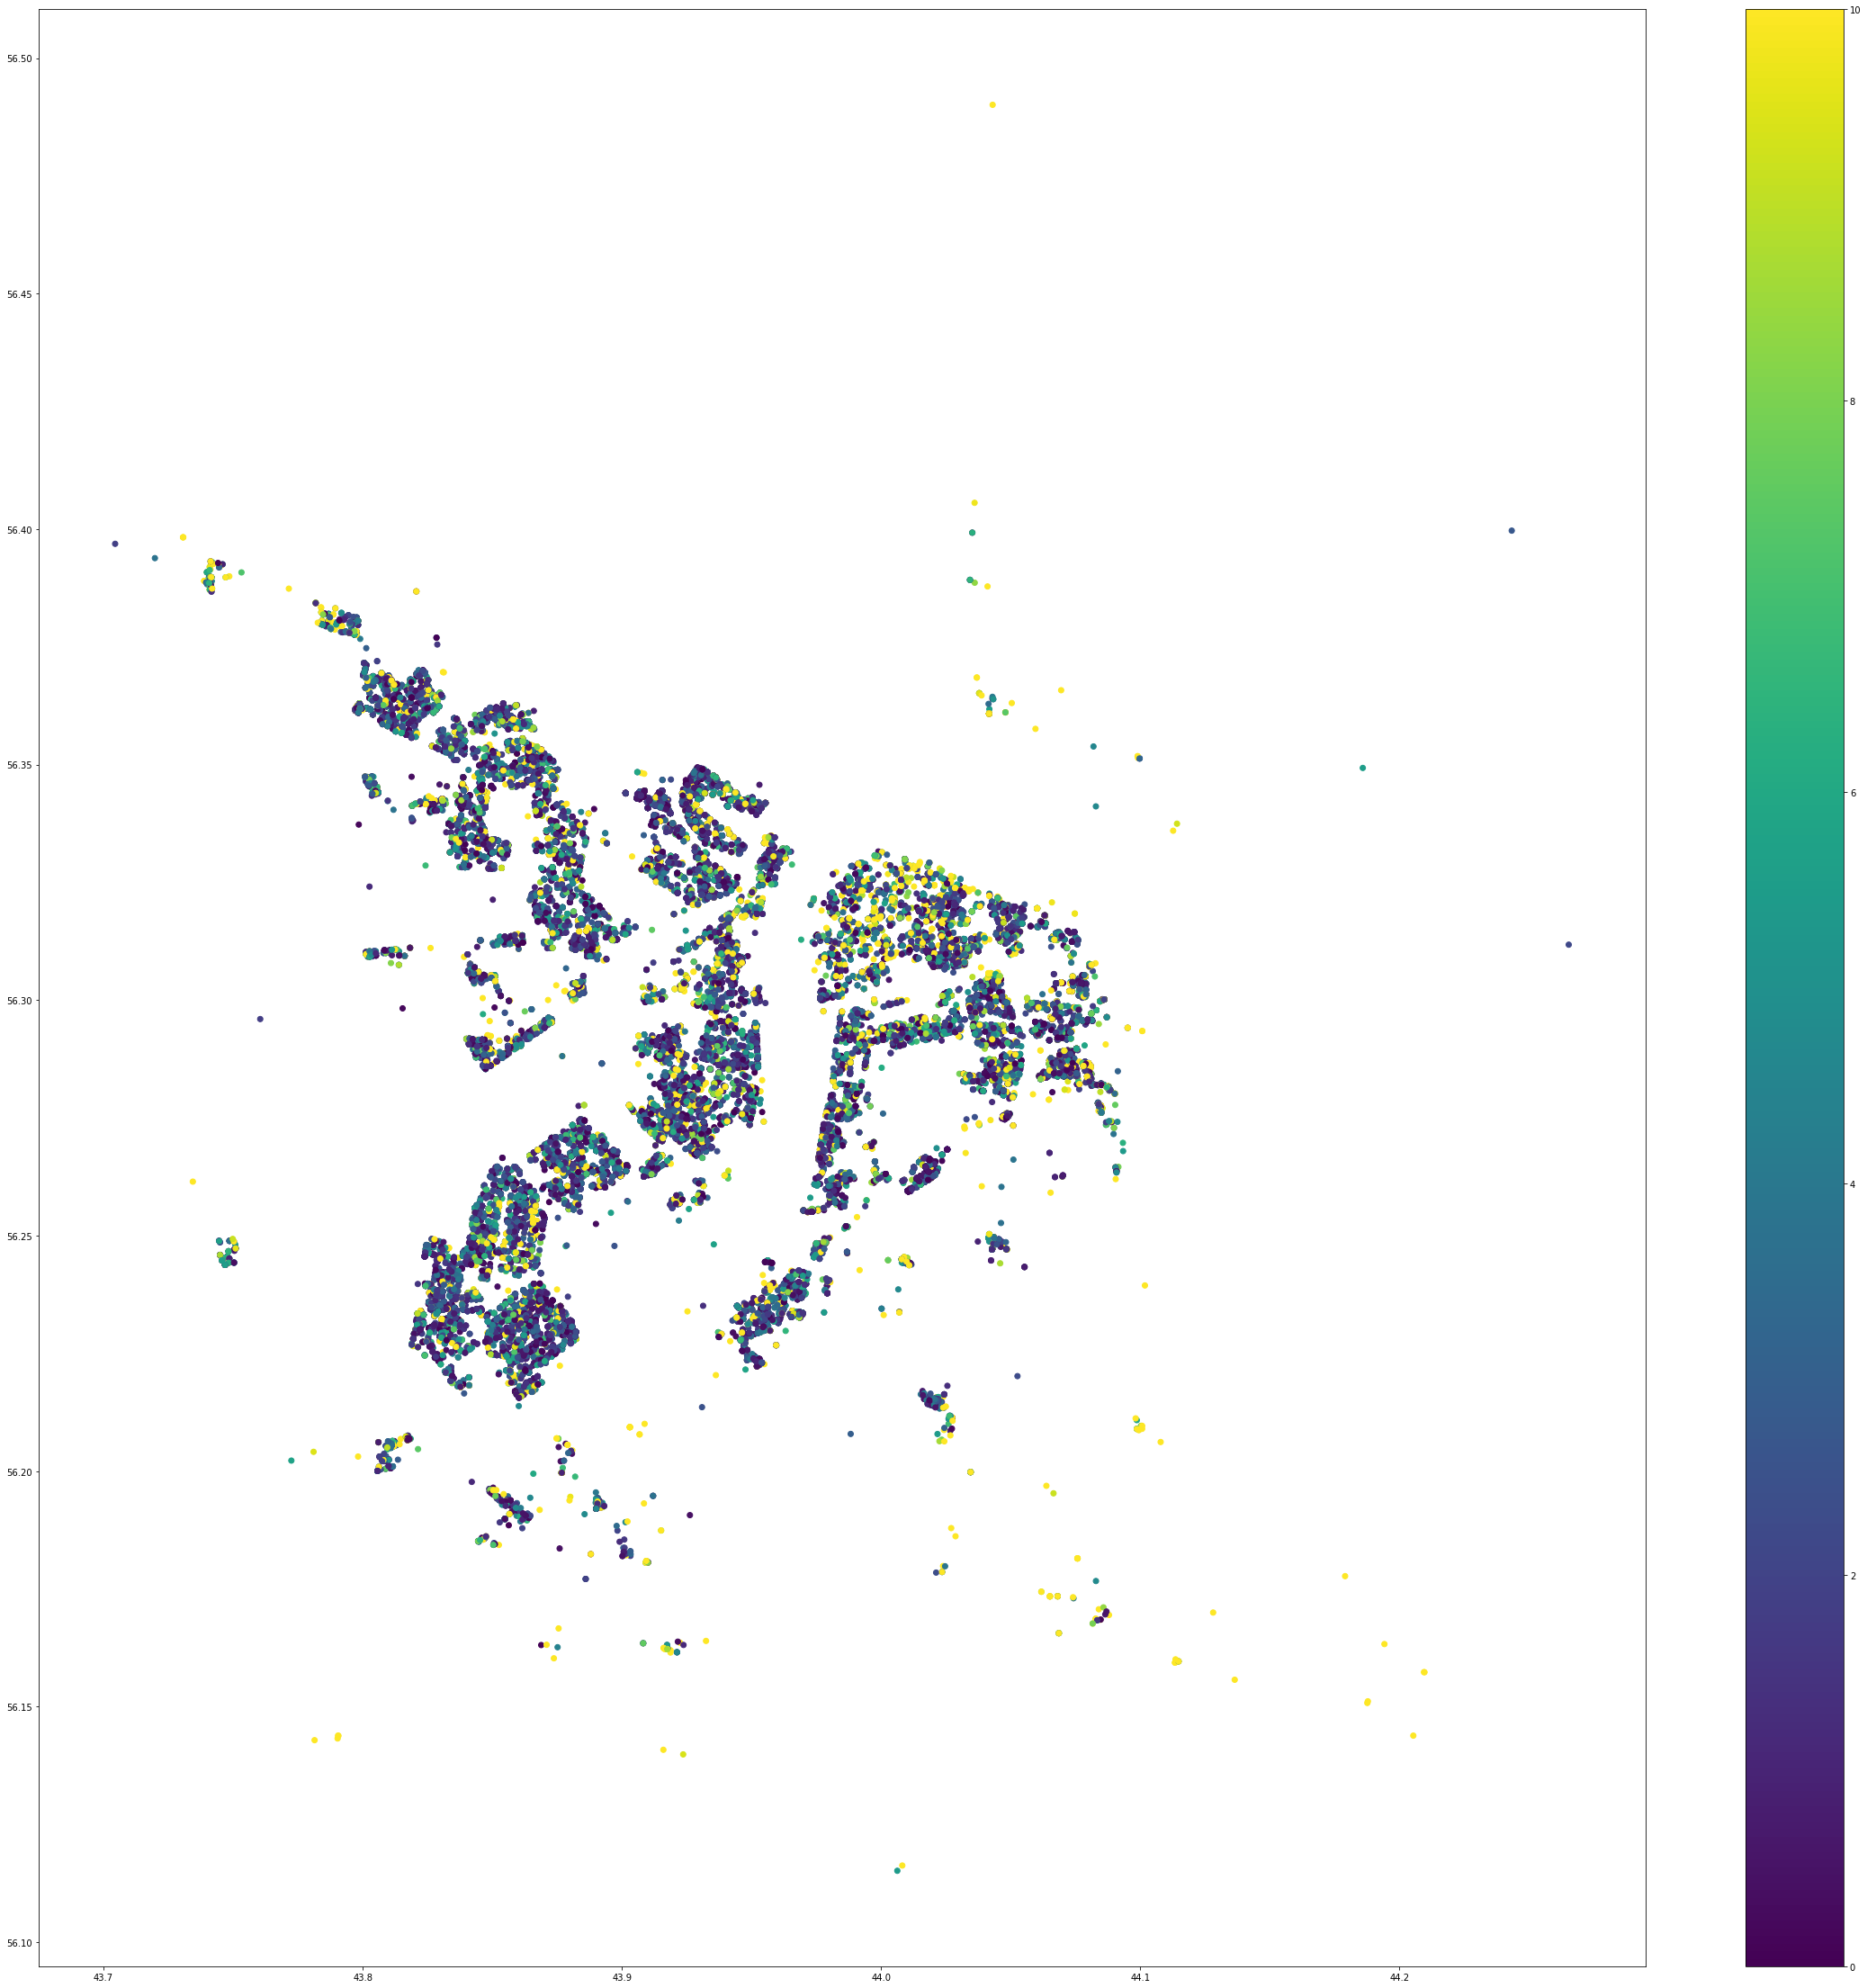

In [3]:
Y_predict = np.array( Y_predict )
Y_values  = np.array( Y_values  )

Y_relErr = np.abs( Y_predict - Y_values )*100/Y_values
for threshold in [ 2.5, 5.0, 10.0 ]:
    bad_s  = np.sum( ( Y_relErr  > threshold ).astype( np.int ) )
    good_s = np.sum( ( Y_relErr <= threshold ).astype( np.int ) )
    print("threshold = {:5}, good = {:10}, bad = {:10}, err = {:4}".format( threshold, good_s, bad_s, bad_s/(good_s+bad_s)) )
x =  X_values[:,0]; y = X_values[:,1]; c = np.minimum(  Y_relErr, 10 );

plt.figure(figsize=(40,40))

plt.scatter (x, y, c=c  )
plt.colorbar()
plt.show    ()

In [4]:
from commonModel import MAX_LONGITUDE, MIN_LONGITUDE, MAX_LATITUDE, MIN_LATITUDE

import warnings
warnings.filterwarnings('ignore')

topK = 10

eps_x = ( MAX_LONGITUDE - MIN_LONGITUDE )*0.001
eps_y = ( MAX_LATITUDE  - MIN_LATITUDE  )*0.001
eps   = min( eps_x, eps_y )

topRelErrIndices = Y_relErr.argsort()[-topK:][::-1]
for i in topRelErrIndices :
    base_row = allDataFrame.iloc[ i ]
    base_x = base_row.longitude 
    base_y = base_row.latitude  
    print("BASE record")
    print( base_row )
    
    for index, cand_row in allDataFrame.iterrows():
        cand_x = cand_row.longitude
        cand_y = cand_row.latitude
        
        distance = np.sqrt( (cand_x-base_x)*(cand_x-base_x) + (cand_y-base_y)*(cand_y-base_y) )
        if distance < eps :
            print("CLOSEST record")
            print( cand_row )
    print("")
    

BASE record
type                Вторичка
price               1.85e+06
longitude            43.8542
latitude             56.3586
total_square              59
living_square             43
kitchen_square            12
number_of_rooms            2
floor_number               3
number_of_floors          10
building_type               
Name: 39068, dtype: object
CLOSEST record
type                 Вторичка
price                 3.3e+06
longitude             43.8542
latitude              56.3586
total_square             40.6
living_square            18.7
kitchen_square            9.8
number_of_rooms             1
floor_number                2
number_of_floors           10
building_type       Кирпичный
Name: 12104, dtype: object
CLOSEST record
type                 Вторичка
price                 3.3e+06
longitude             43.8542
latitude              56.3586
total_square               43
living_square              19
kitchen_square             10
number_of_rooms             1
floor_number   

CLOSEST record
type                 Вторичка
price                 5.8e+06
longitude             43.9305
latitude               56.281
total_square             73.8
living_square              63
kitchen_square            7.6
number_of_rooms             3
floor_number                1
number_of_floors            5
building_type       Кирпичный
Name: 7512, dtype: object
CLOSEST record
type                 Вторичка
price                  750000
longitude             43.9305
latitude               56.281
total_square               18
living_square              18
kitchen_square              9
number_of_rooms             1
floor_number                2
number_of_floors            5
building_type       Кирпичный
Name: 100286, dtype: object

BASE record
type                Вторичка
price                3.5e+06
longitude             44.006
latitude             56.3269
total_square             104
living_square             66
kitchen_square             9
number_of_rooms            5
floor_numbe

CLOSEST record
type                Вторичка
price                  4e+06
longitude             44.006
latitude             56.3269
total_square              71
living_square             36
kitchen_square          12.5
number_of_rooms            2
floor_number               9
number_of_floors          10
building_type               
Name: 4317, dtype: object
CLOSEST record
type                Вторичка
price                2.7e+06
longitude             44.006
latitude             56.3269
total_square              46
living_square             31
kitchen_square             6
number_of_rooms            2
floor_number               5
number_of_floors           5
building_type               
Name: 4961, dtype: object
CLOSEST record
type                Вторичка
price                5.4e+06
longitude             44.006
latitude             56.3269
total_square             110
living_square           65.7
kitchen_square           7.7
number_of_rooms            5
floor_number               3
numb

CLOSEST record
type                 Вторичка
price                 2.6e+06
longitude              44.006
latitude              56.3269
total_square               42
living_square              29
kitchen_square            5.8
number_of_rooms             2
floor_number                3
number_of_floors            5
building_type       Кирпичный
Name: 8929, dtype: object
CLOSEST record
type                 Вторичка
price                   4e+06
longitude              44.006
latitude              56.3269
total_square               68
living_square              44
kitchen_square            7.5
number_of_rooms             3
floor_number                5
number_of_floors            9
building_type       Панельный
Name: 8931, dtype: object
CLOSEST record
type                 Вторичка
price                   3e+06
longitude              44.006
latitude              56.3269
total_square               63
living_square            43.9
kitchen_square            7.1
number_of_rooms             3
flo

CLOSEST record
type                Вторичка
price                2.3e+06
longitude             44.006
latitude             56.3269
total_square              33
living_square           17.5
kitchen_square           7.8
number_of_rooms            1
floor_number               7
number_of_floors           9
building_type               
Name: 12409, dtype: object
CLOSEST record
type                 Вторичка
price                 4.8e+06
longitude              44.006
latitude              56.3269
total_square               57
living_square              30
kitchen_square             12
number_of_rooms             2
floor_number                9
number_of_floors           10
building_type       Кирпичный
Name: 12423, dtype: object
CLOSEST record
type                 Вторичка
price                2.42e+06
longitude              44.006
latitude              56.3269
total_square               34
living_square              17
kitchen_square              8
number_of_rooms             1
floor_number

Name: 16418, dtype: object
CLOSEST record
type                Вторичка
price               1.55e+06
longitude             44.006
latitude             56.3269
total_square              43
living_square             31
kitchen_square             6
number_of_rooms            3
floor_number               2
number_of_floors           2
building_type               
Name: 16610, dtype: object
CLOSEST record
type                Вторичка
price               4.45e+06
longitude             44.006
latitude             56.3269
total_square              87
living_square             57
kitchen_square           9.2
number_of_rooms            4
floor_number               9
number_of_floors           9
building_type               
Name: 16624, dtype: object
CLOSEST record
type                Вторичка
price                4.1e+06
longitude             44.006
latitude             56.3269
total_square              60
living_square             33
kitchen_square            10
number_of_rooms            2
floo

CLOSEST record
type                Вторичка
price               3.95e+06
longitude             44.006
latitude             56.3269
total_square              61
living_square             32
kitchen_square             9
number_of_rooms            2
floor_number              12
number_of_floors          12
building_type               
Name: 21549, dtype: object
CLOSEST record
type                Вторичка
price               1.51e+06
longitude             44.006
latitude             56.3269
total_square            36.1
living_square           26.6
kitchen_square             5
number_of_rooms            2
floor_number               4
number_of_floors           4
building_type               
Name: 21596, dtype: object
CLOSEST record
type                Вторичка
price               2.17e+06
longitude             44.006
latitude             56.3269
total_square              36
living_square             18
kitchen_square            11
number_of_rooms            1
floor_number               2
nu

CLOSEST record
type                Вторичка
price                5.7e+06
longitude             44.006
latitude             56.3269
total_square             108
living_square             75
kitchen_square            10
number_of_rooms            5
floor_number               4
number_of_floors          13
building_type               
Name: 26941, dtype: object
CLOSEST record
type                Вторичка
price               3.25e+06
longitude             44.006
latitude             56.3269
total_square            57.6
living_square           38.8
kitchen_square           8.9
number_of_rooms            3
floor_number               3
number_of_floors           9
building_type               
Name: 27136, dtype: object
CLOSEST record
type                Вторичка
price               3.65e+06
longitude             44.006
latitude             56.3269
total_square              56
living_square             40
kitchen_square           6.5
number_of_rooms            2
floor_number               3
nu

CLOSEST record
type                Вторичка
price                1.7e+06
longitude             44.006
latitude             56.3269
total_square              31
living_square             21
kitchen_square             5
number_of_rooms            1
floor_number               1
number_of_floors           2
building_type               
Name: 36316, dtype: object
CLOSEST record
type                Вторичка
price                2.9e+06
longitude             44.006
latitude             56.3269
total_square              41
living_square           20.5
kitchen_square          10.6
number_of_rooms            1
floor_number               3
number_of_floors           8
building_type        Блочный
Name: 36694, dtype: object
CLOSEST record
type                 Вторичка
price                   3e+06
longitude              44.006
latitude              56.3269
total_square             59.9
living_square              42
kitchen_square            6.5
number_of_rooms             4
floor_number           

CLOSEST record
type                Вторичка
price               3.99e+06
longitude             44.006
latitude             56.3269
total_square            80.2
living_square           50.5
kitchen_square          14.5
number_of_rooms            3
floor_number               8
number_of_floors          14
building_type               
Name: 42662, dtype: object
CLOSEST record
type                 Вторичка
price                 3.4e+06
longitude              44.006
latitude              56.3269
total_square             62.7
living_square              38
kitchen_square            7.4
number_of_rooms             3
floor_number                4
number_of_floors            9
building_type       Панельный
Name: 42668, dtype: object
CLOSEST record
type                 Вторичка
price                 4.3e+06
longitude              44.006
latitude              56.3269
total_square             68.7
living_square            48.1
kitchen_square            9.6
number_of_rooms             3
floor_number

CLOSEST record
type                Вторичка
price               1.85e+06
longitude             44.006
latitude             56.3269
total_square              38
living_square             17
kitchen_square            10
number_of_rooms            1
floor_number               2
number_of_floors           5
building_type               
Name: 52428, dtype: object
CLOSEST record
type                Вторичка
price               3.15e+06
longitude             44.006
latitude             56.3269
total_square            61.5
living_square             48
kitchen_square           6.5
number_of_rooms            3
floor_number               4
number_of_floors           5
building_type               
Name: 53144, dtype: object
CLOSEST record
type                  Вторичка
price                 2.95e+06
longitude               44.006
latitude               56.3269
total_square                41
living_square             16.5
kitchen_square              10
number_of_rooms              1
floor_number   

CLOSEST record
type                Новостройка
price                   1.5e+06
longitude                44.006
latitude                56.3269
total_square               30.7
living_square              15.7
kitchen_square              8.4
number_of_rooms               1
floor_number                  3
number_of_floors              3
building_type         Панельный
Name: 61816, dtype: object
CLOSEST record
type                 Вторичка
price                1.74e+06
longitude              44.006
latitude              56.3269
total_square             32.2
living_square            18.4
kitchen_square            5.1
number_of_rooms             1
floor_number                3
number_of_floors            5
building_type       Панельный
Name: 61928, dtype: object
CLOSEST record
type                 Вторичка
price                 3.1e+06
longitude              44.006
latitude              56.3269
total_square             38.8
living_square              15
kitchen_square              9
number_of

type                 Вторичка
price                 2.2e+06
longitude              44.006
latitude              56.3269
total_square             45.2
living_square              30
kitchen_square              6
number_of_rooms             2
floor_number                5
number_of_floors            5
building_type       Панельный
Name: 68225, dtype: object
CLOSEST record
type                 Вторичка
price                1.45e+06
longitude              44.006
latitude              56.3269
total_square             32.5
living_square              17
kitchen_square              9
number_of_rooms             1
floor_number                1
number_of_floors            3
building_type       Кирпичный
Name: 68226, dtype: object
CLOSEST record
type                 Вторичка
price                 3.6e+06
longitude              44.006
latitude              56.3269
total_square             63.2
living_square            44.7
kitchen_square              7
number_of_rooms             3
floor_number    

type                 Вторичка
price                1.85e+06
longitude              44.006
latitude              56.3269
total_square             29.4
living_square            17.3
kitchen_square            5.2
number_of_rooms             1
floor_number                4
number_of_floors            6
building_type       Кирпичный
Name: 79356, dtype: object
CLOSEST record
type                 Вторичка
price                   3e+06
longitude              44.006
latitude              56.3269
total_square               44
living_square            27.5
kitchen_square              7
number_of_rooms             2
floor_number                7
number_of_floors            9
building_type       Панельный
Name: 79369, dtype: object
CLOSEST record
type                 Вторичка
price                1.49e+06
longitude              44.006
latitude              56.3269
total_square             25.4
living_square            15.4
kitchen_square              5
number_of_rooms             1
floor_number    

CLOSEST record
type                 Вторичка
price                4.75e+06
longitude              44.006
latitude              56.3269
total_square             84.6
living_square            55.5
kitchen_square              9
number_of_rooms             4
floor_number                2
number_of_floors            4
building_type       Кирпичный
Name: 86843, dtype: object
CLOSEST record
type                 Вторичка
price                3.09e+06
longitude              44.006
latitude              56.3269
total_square               43
living_square              12
kitchen_square             18
number_of_rooms             2
floor_number               14
number_of_floors           16
building_type       Кирпичный
Name: 86845, dtype: object
CLOSEST record
type                 Вторичка
price                3.12e+06
longitude              44.006
latitude              56.3269
total_square             63.9
living_square            38.6
kitchen_square            9.4
number_of_rooms             3
f

Name: 90751, dtype: object
CLOSEST record
type                Вторичка
price                3.2e+06
longitude             44.006
latitude             56.3269
total_square              53
living_square             37
kitchen_square             7
number_of_rooms            3
floor_number               8
number_of_floors           9
building_type               
Name: 90765, dtype: object
CLOSEST record
type                 Вторичка
price                 2.2e+06
longitude              44.006
latitude              56.3269
total_square             43.1
living_square            28.4
kitchen_square            5.2
number_of_rooms             2
floor_number                4
number_of_floors            5
building_type       Кирпичный
Name: 90932, dtype: object
CLOSEST record
type                Новостройка
price                  2.25e+06
longitude                44.006
latitude                56.3269
total_square                 53
living_square                33
kitchen_square               11
n

CLOSEST record
type                Вторичка
price                1.9e+06
longitude             44.006
latitude             56.3269
total_square            30.5
living_square           16.5
kitchen_square           6.5
number_of_rooms            1
floor_number               4
number_of_floors           5
building_type               
Name: 97973, dtype: object
CLOSEST record
type                 Вторичка
price                 9.5e+06
longitude              44.006
latitude              56.3269
total_square              130
living_square              60
kitchen_square             25
number_of_rooms             3
floor_number                1
number_of_floors            5
building_type       Кирпичный
Name: 98045, dtype: object
CLOSEST record
type                 Вторичка
price                1.17e+07
longitude              44.006
latitude              56.3269
total_square              150
living_square              80
kitchen_square             16
number_of_rooms             4
floor_number

CLOSEST record
type                 Вторичка
price               2.499e+06
longitude              44.006
latitude              56.3269
total_square               49
living_square              32
kitchen_square              6
number_of_rooms             2
floor_number                4
number_of_floors            5
building_type       Панельный
Name: 106858, dtype: object
CLOSEST record
type                Вторичка
price                3.1e+06
longitude             44.006
latitude             56.3269
total_square              65
living_square             38
kitchen_square             9
number_of_rooms            3
floor_number               2
number_of_floors           9
building_type               
Name: 106999, dtype: object
CLOSEST record
type                 Вторичка
price                9.65e+06
longitude              44.006
latitude              56.3269
total_square              130
living_square              85
kitchen_square             20
number_of_rooms             4
floor_numb


BASE record
type                 Вторичка
price                  650000
longitude             43.9325
latitude               56.277
total_square             16.1
living_square            16.1
kitchen_square           16.1
number_of_rooms             1
floor_number                2
number_of_floors            2
building_type       Кирпичный
Name: 98504, dtype: object
CLOSEST record
type                 Вторичка
price                  650000
longitude             43.9325
latitude               56.277
total_square             16.1
living_square            16.1
kitchen_square           16.1
number_of_rooms             1
floor_number                2
number_of_floors            2
building_type       Кирпичный
Name: 98504, dtype: object

BASE record
type                 Вторичка
price                 2.5e+06
longitude              44.006
latitude              56.3269
total_square               75
living_square              44
kitchen_square             10
number_of_rooms             3
floor

CLOSEST record
type                Вторичка
price                2.2e+06
longitude             44.006
latitude             56.3269
total_square              34
living_square             18
kitchen_square           9.2
number_of_rooms            1
floor_number               5
number_of_floors           9
building_type               
Name: 3471, dtype: object
CLOSEST record
type                Вторичка
price                  4e+06
longitude             44.006
latitude             56.3269
total_square              71
living_square             36
kitchen_square          12.5
number_of_rooms            2
floor_number               9
number_of_floors          10
building_type               
Name: 4317, dtype: object
CLOSEST record
type                Вторичка
price                2.7e+06
longitude             44.006
latitude             56.3269
total_square              46
living_square             31
kitchen_square             6
number_of_rooms            2
floor_number               5
numb

CLOSEST record
type                 Вторичка
price               1.799e+06
longitude              44.006
latitude              56.3269
total_square               30
living_square              18
kitchen_square            5.5
number_of_rooms             1
floor_number                9
number_of_floors            9
building_type       Кирпичный
Name: 11685, dtype: object
CLOSEST record
type                 Вторичка
price                 1.8e+06
longitude              44.006
latitude              56.3269
total_square               31
living_square            17.7
kitchen_square              6
number_of_rooms             1
floor_number                6
number_of_floors            6
building_type       Кирпичный
Name: 11698, dtype: object
CLOSEST record
type                 Вторичка
price                1.65e+06
longitude              44.006
latitude              56.3269
total_square               23
living_square              11
kitchen_square              6
number_of_rooms             1
f

CLOSEST record
type                 Вторичка
price                 2.5e+06
longitude              44.006
latitude              56.3269
total_square               50
living_square              30
kitchen_square              9
number_of_rooms             2
floor_number                6
number_of_floors            9
building_type       Панельный
Name: 17208, dtype: object
CLOSEST record
type                 Вторичка
price                1.72e+06
longitude              44.006
latitude              56.3269
total_square               45
living_square              29
kitchen_square              8
number_of_rooms             2
floor_number                3
number_of_floors            3
building_type       Кирпичный
Name: 17212, dtype: object
CLOSEST record
type                 Вторичка
price               2.915e+06
longitude              44.006
latitude              56.3269
total_square               49
living_square              30
kitchen_square              9
number_of_rooms             2
f

CLOSEST record
type                Вторичка
price               3.05e+06
longitude             44.006
latitude             56.3269
total_square            47.1
living_square           27.5
kitchen_square           8.2
number_of_rooms            2
floor_number               8
number_of_floors           9
building_type               
Name: 22467, dtype: object
CLOSEST record
type                Вторичка
price               3.15e+06
longitude             44.006
latitude             56.3269
total_square            58.3
living_square           38.4
kitchen_square           8.8
number_of_rooms            3
floor_number               7
number_of_floors           9
building_type               
Name: 22544, dtype: object
CLOSEST record
type                Вторичка
price                3.5e+06
longitude             44.006
latitude             56.3269
total_square            60.5
living_square           44.3
kitchen_square             7
number_of_rooms            3
floor_number               6
nu

CLOSEST record
type                Вторичка
price               2.16e+06
longitude             44.006
latitude             56.3269
total_square              31
living_square             18
kitchen_square             6
number_of_rooms            1
floor_number               5
number_of_floors           5
building_type               
Name: 28642, dtype: object
CLOSEST record
type                 Вторичка
price                 5.6e+06
longitude              44.006
latitude              56.3269
total_square               96
living_square              54
kitchen_square             18
number_of_rooms             3
floor_number                2
number_of_floors            5
building_type       Кирпичный
Name: 28939, dtype: object
CLOSEST record
type                 Вторичка
price                 3.6e+06
longitude              44.006
latitude              56.3269
total_square             48.3
living_square              24
kitchen_square           12.6
number_of_rooms             1
floor_number

type                  Вторичка
price                 3.65e+06
longitude               44.006
latitude               56.3269
total_square              49.2
living_square               28
kitchen_square               9
number_of_rooms              1
floor_number                 8
number_of_floors            10
building_type       Монолитный
Name: 35082, dtype: object
CLOSEST record
type                 Вторичка
price                 2.1e+06
longitude              44.006
latitude              56.3269
total_square               43
living_square              29
kitchen_square            5.8
number_of_rooms             2
floor_number                5
number_of_floors            5
building_type       Панельный
Name: 35088, dtype: object
CLOSEST record
type                 Вторичка
price                1.86e+06
longitude              44.006
latitude              56.3269
total_square               43
living_square              37
kitchen_square              6
number_of_rooms             2
floor

Name: 42496, dtype: object
CLOSEST record
type                 Вторичка
price                3.55e+06
longitude              44.006
latitude              56.3269
total_square               64
living_square              44
kitchen_square            7.1
number_of_rooms             3
floor_number                3
number_of_floors            9
building_type       Панельный
Name: 42552, dtype: object
CLOSEST record
type                 Вторичка
price                3.95e+06
longitude              44.006
latitude              56.3269
total_square               58
living_square            38.5
kitchen_square            7.5
number_of_rooms             3
floor_number                6
number_of_floors            9
building_type       Кирпичный
Name: 42554, dtype: object
CLOSEST record
type                Вторичка
price               3.99e+06
longitude             44.006
latitude             56.3269
total_square            80.2
living_square           50.5
kitchen_square          14.5
number_of_r

CLOSEST record
type                Новостройка
price                  2.89e+06
longitude                44.006
latitude                56.3269
total_square                 50
living_square                24
kitchen_square               10
number_of_rooms               2
floor_number                 10
number_of_floors             17
building_type                  
Name: 50587, dtype: object
CLOSEST record
type                Вторичка
price               1.85e+06
longitude             44.006
latitude             56.3269
total_square              38
living_square             17
kitchen_square            10
number_of_rooms            1
floor_number               2
number_of_floors           5
building_type               
Name: 52428, dtype: object
CLOSEST record
type                Вторичка
price               3.15e+06
longitude             44.006
latitude             56.3269
total_square            61.5
living_square             48
kitchen_square           6.5
number_of_rooms            

Name: 61466, dtype: object
CLOSEST record
type                Новостройка
price                   1.5e+06
longitude                44.006
latitude                56.3269
total_square               30.7
living_square              15.7
kitchen_square              8.4
number_of_rooms               1
floor_number                  3
number_of_floors              3
building_type         Панельный
Name: 61816, dtype: object
CLOSEST record
type                 Вторичка
price                1.74e+06
longitude              44.006
latitude              56.3269
total_square             32.2
living_square            18.4
kitchen_square            5.1
number_of_rooms             1
floor_number                3
number_of_floors            5
building_type       Панельный
Name: 61928, dtype: object
CLOSEST record
type                 Вторичка
price                 3.1e+06
longitude              44.006
latitude              56.3269
total_square             38.8
living_square              15
kitchen_squa

CLOSEST record
type                Вторичка
price                3.7e+06
longitude             44.006
latitude             56.3269
total_square              61
living_square             45
kitchen_square           7.5
number_of_rooms            3
floor_number               1
number_of_floors           9
building_type               
Name: 70871, dtype: object
CLOSEST record
type                 Вторичка
price                 1.7e+06
longitude              44.006
latitude              56.3269
total_square               22
living_square              12
kitchen_square            5.5
number_of_rooms             1
floor_number                6
number_of_floors            9
building_type       Кирпичный
Name: 70921, dtype: object
CLOSEST record
type                 Вторичка
price                 2.1e+06
longitude              44.006
latitude              56.3269
total_square             44.3
living_square              28
kitchen_square              6
number_of_rooms             2
floor_number

CLOSEST record
type                 Вторичка
price                1.55e+06
longitude              44.006
latitude              56.3269
total_square               31
living_square              18
kitchen_square            5.5
number_of_rooms             1
floor_number                5
number_of_floors            5
building_type       Кирпичный
Name: 81596, dtype: object
CLOSEST record
type                 Вторичка
price                3.65e+06
longitude              44.006
latitude              56.3269
total_square               52
living_square            32.8
kitchen_square            6.1
number_of_rooms             2
floor_number                5
number_of_floors            9
building_type       Кирпичный
Name: 81674, dtype: object
CLOSEST record
type                 Вторичка
price                1.39e+06
longitude              44.006
latitude              56.3269
total_square               29
living_square              18
kitchen_square              5
number_of_rooms             1
f

Name: 88006, dtype: object
CLOSEST record
type                Вторичка
price                6.9e+06
longitude             44.006
latitude             56.3269
total_square           116.6
living_square           64.2
kitchen_square          14.4
number_of_rooms            4
floor_number               1
number_of_floors          10
building_type               
Name: 88029, dtype: object
CLOSEST record
type                 Вторичка
price                3.85e+06
longitude              44.006
latitude              56.3269
total_square               58
living_square            38.5
kitchen_square            7.5
number_of_rooms             3
floor_number                6
number_of_floors            9
building_type       Кирпичный
Name: 88317, dtype: object
CLOSEST record
type                 Вторичка
price                 3.4e+06
longitude              44.006
latitude              56.3269
total_square             64.2
living_square            38.6
kitchen_square            9.4
number_of_rooms

CLOSEST record
type                 Вторичка
price                 3.4e+06
longitude              44.006
latitude              56.3269
total_square               59
living_square              32
kitchen_square              9
number_of_rooms             2
floor_number               19
number_of_floors           20
building_type       Панельный
Name: 93157, dtype: object
CLOSEST record
type                  Вторичка
price                 1.18e+06
longitude               44.006
latitude               56.3269
total_square              33.5
living_square               18
kitchen_square              10
number_of_rooms              1
floor_number                 1
number_of_floors             2
building_type       Деревянный
Name: 93158, dtype: object
CLOSEST record
type                 Вторичка
price                1.88e+06
longitude              44.006
latitude              56.3269
total_square               39
living_square              17
kitchen_square              9
number_of_rooms     

CLOSEST record
type                  Вторичка
price                  3.2e+06
longitude               44.006
latitude               56.3269
total_square              38.7
living_square             17.5
kitchen_square               9
number_of_rooms              1
floor_number                 1
number_of_floors            23
building_type       Монолитный
Name: 99823, dtype: object
CLOSEST record
type                 Вторичка
price                 2.5e+06
longitude              44.006
latitude              56.3269
total_square               55
living_square              27
kitchen_square             13
number_of_rooms             2
floor_number                8
number_of_floors           16
building_type       Кирпичный
Name: 99825, dtype: object
CLOSEST record
type                Вторичка
price               3.25e+06
longitude             44.006
latitude             56.3269
total_square              46
living_square             20
kitchen_square            10
number_of_rooms            

type                 Вторичка
price                4.35e+06
longitude              44.006
latitude              56.3269
total_square             63.7
living_square              39
kitchen_square              9
number_of_rooms             3
floor_number                3
number_of_floors            9
building_type       Кирпичный
Name: 105559, dtype: object
CLOSEST record
type                 Вторичка
price                1.45e+06
longitude              44.006
latitude              56.3269
total_square               29
living_square            17.5
kitchen_square            5.8
number_of_rooms             1
floor_number                2
number_of_floors            5
building_type       Кирпичный
Name: 105563, dtype: object
CLOSEST record
type                 Вторичка
price                2.85e+06
longitude              44.006
latitude              56.3269
total_square               55
living_square            36.5
kitchen_square              6
number_of_rooms             3
floor_number  

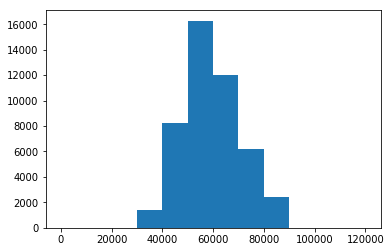

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer

import matplotlib.pyplot as plt

bins = [0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000]

pricePerSquare       = allDataFrame['price']/allDataFrame['total_square']
pricePerSquareValues = pricePerSquare.values

plt.hist(  pricePerSquareValues, bins=bins )
plt.show()
